In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/kaggle/input/llmdetect/XlmRoberta_English_dataset_LLMdetect_balanced.csv")  # replace with your filename
print(df.head())

                                                text  label  \
0  The process begins when the computer construct...      0   
1  \nWhen it comes to advice and wisdom, listenin...      1   
2  There are many people who think that animals s...      1   
3  Imagine being able to detect how other people ...      0   
4  In cities such as Vauban, Paris, and Bogota, p...      0   

                                        cleaned_text  \
0  process begin computer construct computer mode...   
1  come advice wisdom listening elder incredibly ...   
2  many people think animal treated pet people be...   
3  imagine able detect people feeling even trying...   
4  city vauban paris bogota people getting seriou...   

                              XLMRoberta2_embeddings  
0  [ 5.62172681e-02  8.84449780e-02  6.58054575e-...  
1  [ 7.67848641e-02  1.14073060e-01  4.41924185e-...  
2  [ 4.93398756e-02  6.56239912e-02  4.65359576e-...  
3  [ 3.72375101e-02  9.03443843e-02  5.88569790e-...  
4  [ 9.28

In [3]:
import numpy as np
# Convert space-separated embedding strings to numpy arrays
def str_to_array(s):
    s = s.strip("[]")  # remove brackets
    return np.array([float(x) for x in s.split()])

df['XLMRoberta2_embeddings'] = df['XLMRoberta2_embeddings'].apply(str_to_array)


In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Load dataset and convert embeddings
# -----------------------------
df = pd.read_csv("/kaggle/input/llmdetect/XlmRoberta_English_dataset_LLMdetect_balanced.csv")

# Convert space-separated embeddings to numpy arrays
def str_to_array(s):
    s = s.strip("[]")
    return np.array([float(x) for x in s.split()])

df['XLMRoberta2_embeddings'] = df['XLMRoberta2_embeddings'].apply(str_to_array)

X = np.array(df['XLMRoberta2_embeddings'].tolist())
y = np.array(df['label'])

In [2]:
# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmbeddingDataset(X_train, y_train)
val_dataset = EmbeddingDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [3]:
# -----------------------------
# 2. Build MLP Model
# -----------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, num_classes)
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = MLPClassifier(input_dim)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
# -----------------------------
# 3. Training setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

train_losses, val_losses = [], []
train_accs, val_accs = [], []


In [11]:
 from tqdm.notebook import tqdm

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    # -----------------------------
    # 1. Training
    # -----------------------------
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
    train_loss = total_loss / total
    train_acc = correct / total

    # -----------------------------
    # 2. Validation
    # -----------------------------
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            _, predicted = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    val_loss = val_loss / total
    val_acc = correct / total

    # -----------------------------
    # 3. Save metrics
    # -----------------------------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # -----------------------------
    # 4. Print metrics per epoch
    # -----------------------------
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}", flush=True)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.0739, Train Acc: 0.9760 | Val Loss: 0.0553, Val Acc: 0.9820
Epoch 2/20 | Train Loss: 0.0787, Train Acc: 0.9745 | Val Loss: 0.0566, Val Acc: 0.9800
Epoch 3/20 | Train Loss: 0.0793, Train Acc: 0.9730 | Val Loss: 0.0772, Val Acc: 0.9730
Epoch 4/20 | Train Loss: 0.0715, Train Acc: 0.9778 | Val Loss: 0.0519, Val Acc: 0.9840
Epoch 5/20 | Train Loss: 0.0891, Train Acc: 0.9685 | Val Loss: 0.0520, Val Acc: 0.9840
Epoch 6/20 | Train Loss: 0.0700, Train Acc: 0.9762 | Val Loss: 0.0939, Val Acc: 0.9620
Epoch 7/20 | Train Loss: 0.0726, Train Acc: 0.9755 | Val Loss: 0.0548, Val Acc: 0.9830
Epoch 8/20 | Train Loss: 0.0657, Train Acc: 0.9790 | Val Loss: 0.0530, Val Acc: 0.9840
Epoch 9/20 | Train Loss: 0.0728, Train Acc: 0.9772 | Val Loss: 0.0570, Val Acc: 0.9780
Epoch 10/20 | Train Loss: 0.0747, Train Acc: 0.9748 | Val Loss: 0.0940, Val Acc: 0.9650
Epoch 11/20 | Train Loss: 0.0688, Train Acc: 0.9772 | Val Loss: 0.0574, Val Acc: 0.9810
Epoch 12/20 | Train Loss: 0.0592, Train A

In [12]:
# -----------------------------
# 5. Evaluation metrics
# -----------------------------
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, y_pred = torch.max(outputs, 1)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.977
Precision: 0.9735349716446124
Recall: 0.982824427480916
F1 Score: 0.9781576448243114

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       476
           1       0.97      0.98      0.98       524

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



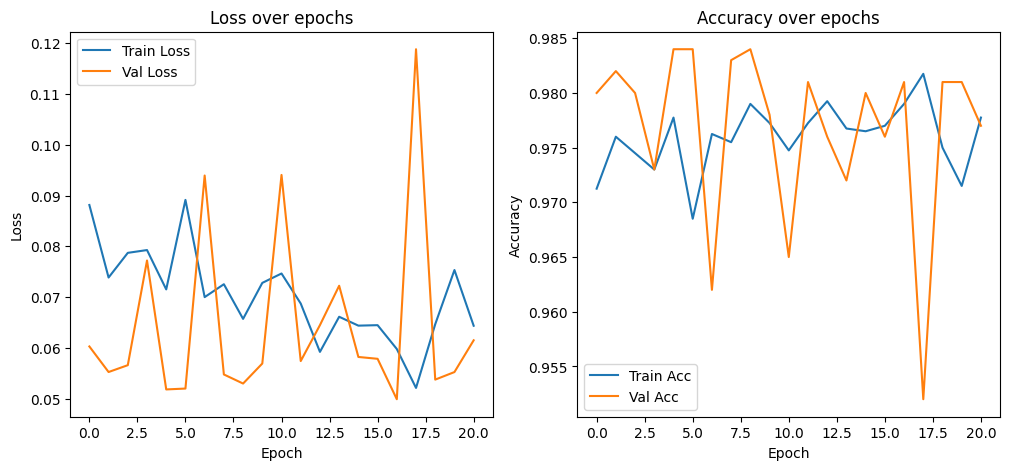

In [13]:
# -----------------------------
# 6. Plot training graphs
# -----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.show()

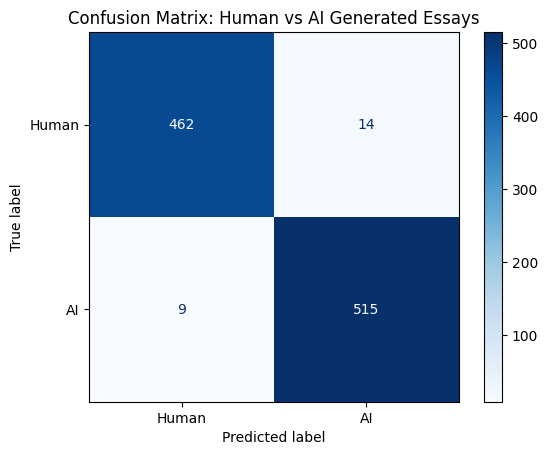

Accuracy: 0.977
Precision: 0.9735349716446124
Recall: 0.982824427480916
F1 Score: 0.9781576448243114

Classification Report:
               precision    recall  f1-score   support

       Human       0.98      0.97      0.98       476
          AI       0.97      0.98      0.98       524

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. Make predictions on validation set
# -----------------------------
model.eval()
with torch.no_grad():
    outputs = model(X_val)                  # X_val is your validation embeddings
    _, y_pred = torch.max(outputs, 1)       # predicted labels

# -----------------------------
# 2. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Human", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Human vs AI Generated Essays")
plt.show()

# -----------------------------
# 3. Detailed Metrics
# -----------------------------
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=["Human", "AI"]))
